# Basic usage

In [11]:
from pyhdx.datasets import read_dynamx
from pyhdx.models import HDXMeasurement
from pyhdx.process import filter_peptides, apply_control, correct_d_uptake
from pyhdx.plot import peptide_coverage
import ultraplot as uplt
from pathlib import Path

We can use the ``read_dynamx`` function to read the input DynamX state file. In these fildes, exposure times in the .csv file are in units of minutes, which are converted to seconds using the `time_conversion` argument.

Any space in column names are replaced with underscores and an additional column 'stop' is added, which is equal to `'end' + 1` such that python-standard `inclusive: exclusive` interval indexing can be used.

This function returns a ``pandas`` DataFrame where each entry corresponds to one peptide, in this example 567 peptides.

In [2]:
fpath = Path() / ".." / ".." / "tests" / "test_data" / "input" / "ecSecB_apo.csv"
data = read_dynamx(fpath, time_conversion=("min", "s"))
data.head()

,protein,start,end,stop,sequence,modification,fragment,maxuptake,mhp,state,exposure,center,center_sd,uptake,uptake_sd,rt,rt_sd
0,Accession,9,17,18,MTFQIQRIY,NaN,NaN,8,1199.6241,Full deuteration control,0.00,1200.412304,0.001798,0.000000,0.000000,5.510866,0.003846
1,Accession,9,17,18,MTFQIQRIY,NaN,NaN,8,1199.6241,Full deuteration control,10.02,1205.485704,0.019962,5.073400,0.020042,5.519758,0.002944
2,Accession,9,17,18,MTFQIQRIY,NaN,NaN,8,1199.6241,SecB WT apo,0.00,1200.411174,0.023301,0.000000,0.000000,5.513296,0.010889
3,Accession,9,17,18,MTFQIQRIY,NaN,NaN,8,1199.6241,SecB WT apo,10.02,1202.897618,0.016323,2.486444,0.028450,5.513900,0.010976
4,Accession,9,17,18,MTFQIQRIY,NaN,NaN,8,1199.6241,SecB WT apo,30.00,1203.268315,0.029992,2.857141,0.037979,5.510626,0.008419


This dataframe contains the peptides for both the fully deuterated control example as well as the experimental peptides measured over multiple deuterium exposure times. The `filter_peptides` function can be used for to separate out peptides by their 'state' and 'exposure' fields.

In [3]:
# Filter out peptides for the full deuteration control
fd_df = filter_peptides(data, state="Full deuteration control", exposure=60 * 0.167)
fd_df["state"].unique(), fd_df["exposure"].unique()

(array(['Full deuteration control'], dtype=object), array([10.02]))

Additionally, the `query` keyword argument can be used to pass a list of additional queries to be applied to the DataFrame. The query strings are passed to [pandas.DataFrame.query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html) and the example below removes all 0 exposure times peptides.

In [4]:
peptides = filter_peptides(data, state="SecB WT apo", query=["exposure > 0."])
peptides["state"].unique(), peptides["exposure"].unique()

(array(['SecB WT apo'], dtype=object),
 array([  10.02   ,   30.     ,   60.     ,  300.     ,  600.     ,
        6000.00048]))

Next, the FD control is applied with the `apply_control` function. This takes the intersection of peptides between the experimental and control peptides and subsequently adds the columns: 'fd_uptake', 'fd_uptake_sd', 'nd_uptake' , 'nd_uptake_sd', 'rfu' and 'rfu_sd'. The 'rfu' fields are Relative Fractional Uptake and are caluculated as:

$$
RFU = \frac{U(t) - ND }{FD - ND}
$$

Where $U(t)$ are deuterium uptake values per peptide as a function of their D-exposure time. Supplying a Non-deuteration control is optional, and is otherwise assumed to be zero.

In [5]:
peptides_control = apply_control(peptides, fd_df, nd_control=None)
peptides_control.head()

,start,end,stop,sequence,state,exposure,uptake,uptake_sd,maxuptake,fd_uptake,...,rfu,rfu_sd,protein,modification,fragment,mhp,center,center_sd,rt,rt_sd
0,9,17,18,MTFQIQRIY,SecB WT apo,10.02,2.486444,0.028450,8,5.0734,...,0.490094,0.005932,Accession,NaN,NaN,1199.6241,1202.897618,0.016323,5.513900,0.010976
1,9,17,18,MTFQIQRIY,SecB WT apo,30.00,2.857141,0.037979,8,5.0734,...,0.563161,0.007809,Accession,NaN,NaN,1199.6241,1203.268315,0.029992,5.510626,0.008419
2,9,17,18,MTFQIQRIY,SecB WT apo,60.00,3.145738,0.046666,8,5.0734,...,0.620045,0.009519,Accession,NaN,NaN,1199.6241,1203.556913,0.040432,5.516562,0.012371
3,9,17,18,MTFQIQRIY,SecB WT apo,300.00,3.785886,0.024942,8,5.0734,...,0.746223,0.005732,Accession,NaN,NaN,1199.6241,1204.197061,0.008898,5.505509,0.004363
4,9,17,18,MTFQIQRIY,SecB WT apo,600.00,4.082950,0.036037,8,5.0734,...,0.804776,0.007782,Accession,NaN,NaN,1199.6241,1204.494124,0.027490,5.522181,0.011556


Next, the measured d-uptake is corrected for backexchange and the percentage of deuterium in solution. For this, the amount of N-terminal residues which are assumed to fully back exchange must be specified (typically best set to 2).

This step modified the 'sequence' field by marking back-exchanging amino acids with 'x', and adds the columns 'ex_residues', which is the total number of exchanging residues given back exchange, prolines and the percentage deuterium, and the column 'uptake_corrected', which is the final corrected D-uptake for the peptide.

In [6]:
peptides_corrected = correct_d_uptake(peptides_control, drop_first=2, d_percentage=90.0)
peptides_corrected.iloc[0]

start                         9
end                          17
stop                         18
sequence              xxFQIQRIY
state               SecB WT apo
exposure                  10.02
uptake                 2.486444
uptake_sd               0.02845
maxuptake                     8
fd_uptake                5.0734
fd_uptake_sd           0.020042
nd_uptake                     0
nd_uptake_sd                  0
rfu                    0.490094
rfu_sd                 0.005932
protein               Accession
modification                NaN
fragment                    NaN
mhp                   1199.6241
center              1202.897618
center_sd              0.016323
rt                       5.5139
rt_sd                  0.010976
_sequence             MTFQIQRIY
_start                       11
_stop                        18
ex_residues                 6.3
uptake_corrected       3.087594
Name: 0, dtype: object

This data array can now be used to create an ``HDXMeasurement`` object, the main data object in PyHDX. Experimental metadata such as labelling pH and temperature (in Kelvin) can be specified. These quantities are required for calculating intrinsic exchange rates and ΔG values. The pH values are uncorrected values are measured by the pH meter (ie p(H, D) values)

In [7]:
sequence = "MSEQNNTEMTFQIQRIYTKDISFEAPNAPHVFQKDWQPEVKLDLDTASSQLADDVYEVVLRVTVTASLGEETAFLCEVQQGGIFSIAGIEGTQMAHCLGAYCPNILFPYARECITSMVSRGTFPQLNLAPVNFDALFMNYLQQQAGEGTEEHQDA"
temperature, pH = 273.15 + 30, 8.0

hdxm = HDXMeasurement(
    peptides_corrected, sequence=sequence, pH=pH, temperature=temperature, name="My HDX measurement"
)
hdxm

HDX Measurement:     My HDX measurement<br><br>Number of peptides:         63<br>Number of residues:         145 (11 - 156)<br>Number of timepoints:       6<br>Timepoints:                 10.02, 30.00, 60.00, 300.00, 600.00, 6000.00 seconds<br>Coverage Percentage:        88.39<br>Average redundancy:         5.04   <br>Average peptide length:     11.89<br>Repeatability (mean std):   0.05 Da<br>Temperature:                303.15 K<br>pH:                         8.0             <br>

Iterating over a ``HDXMeasurement`` object returns a set of ``HDXTimepoint`` each with their own attributes describing the topology of the coverage. When creating the object, peptides which are not present in all timepoints are removed, such that all timepoints and ``HDXTimepoint`` have identical coverage.

Note that the internal time units in PyHDX are seconds.

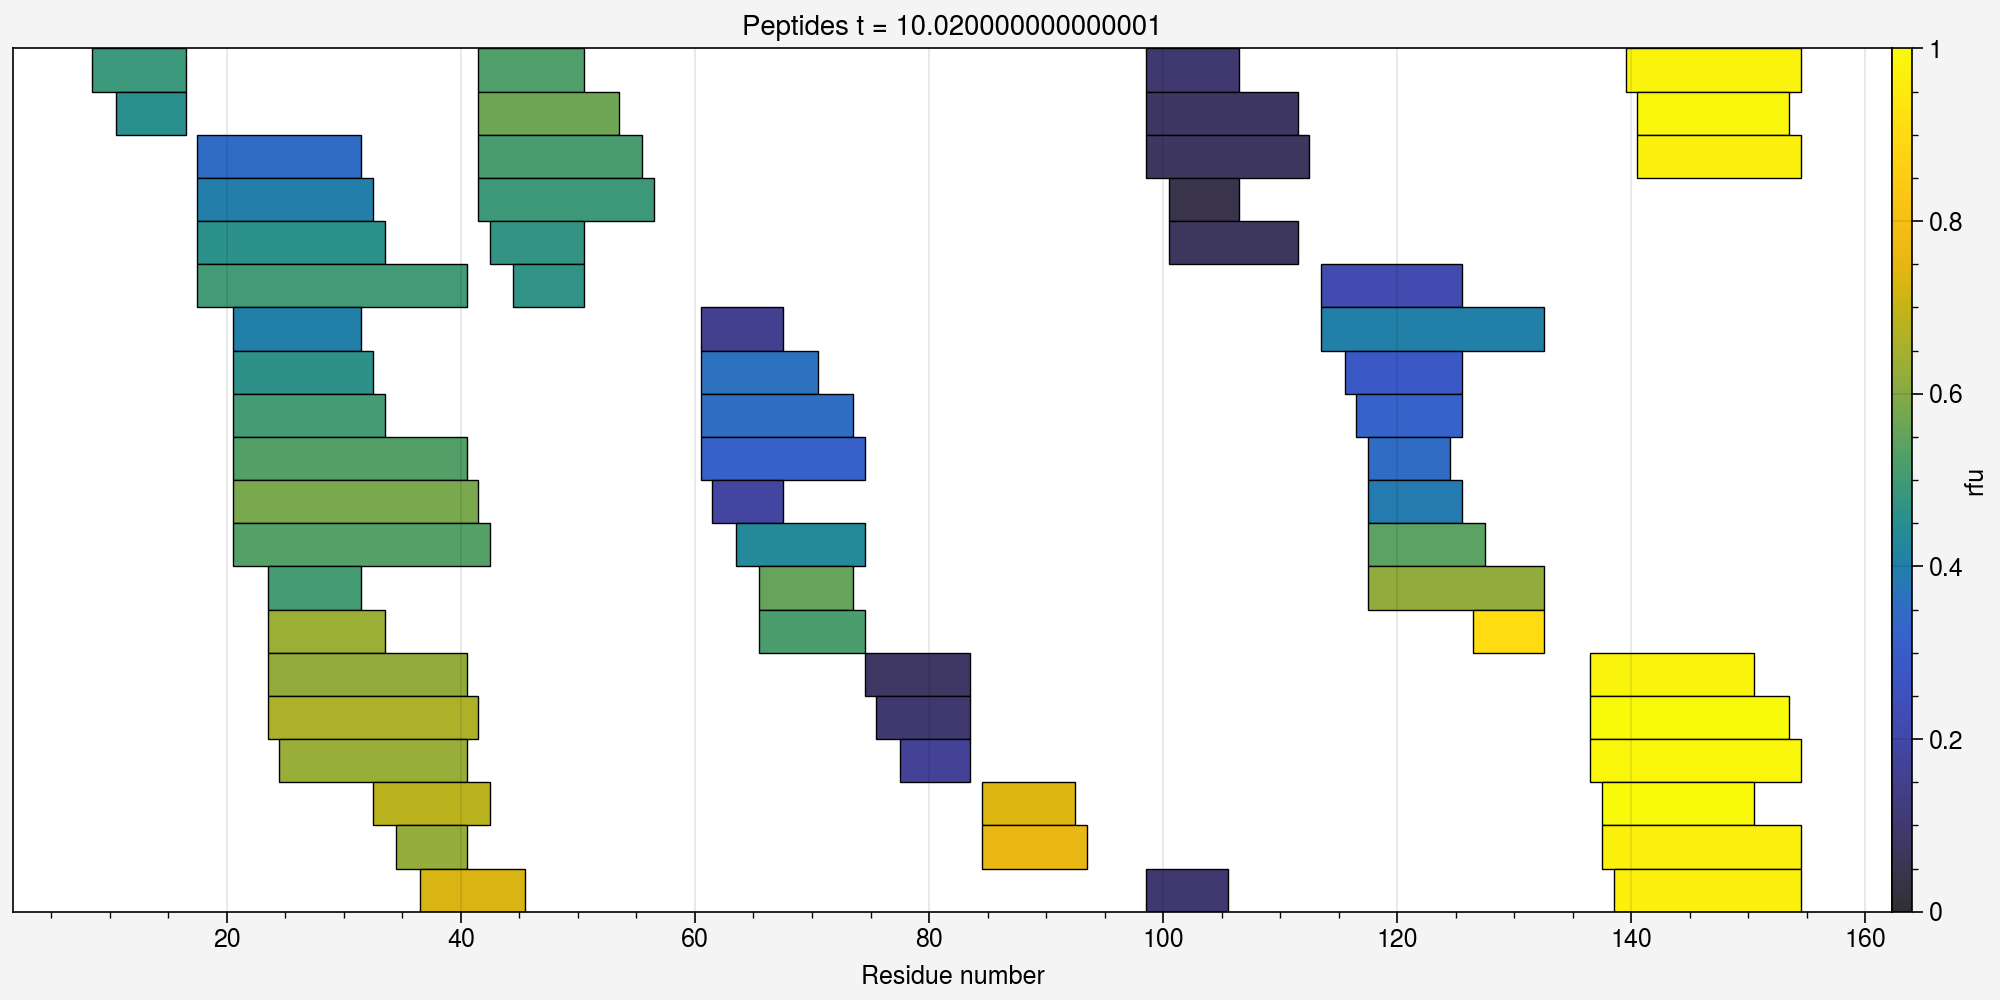

In [8]:
fig, ax = uplt.subplots(figsize=(10, 5))
i = 0
peptide_coverage(ax, hdxm[i].data, 20, cbar=True)
title = ax.set_title(f"Peptides t = {hdxm.timepoints[i]}")
label = ax.set_xlabel("Residue number")

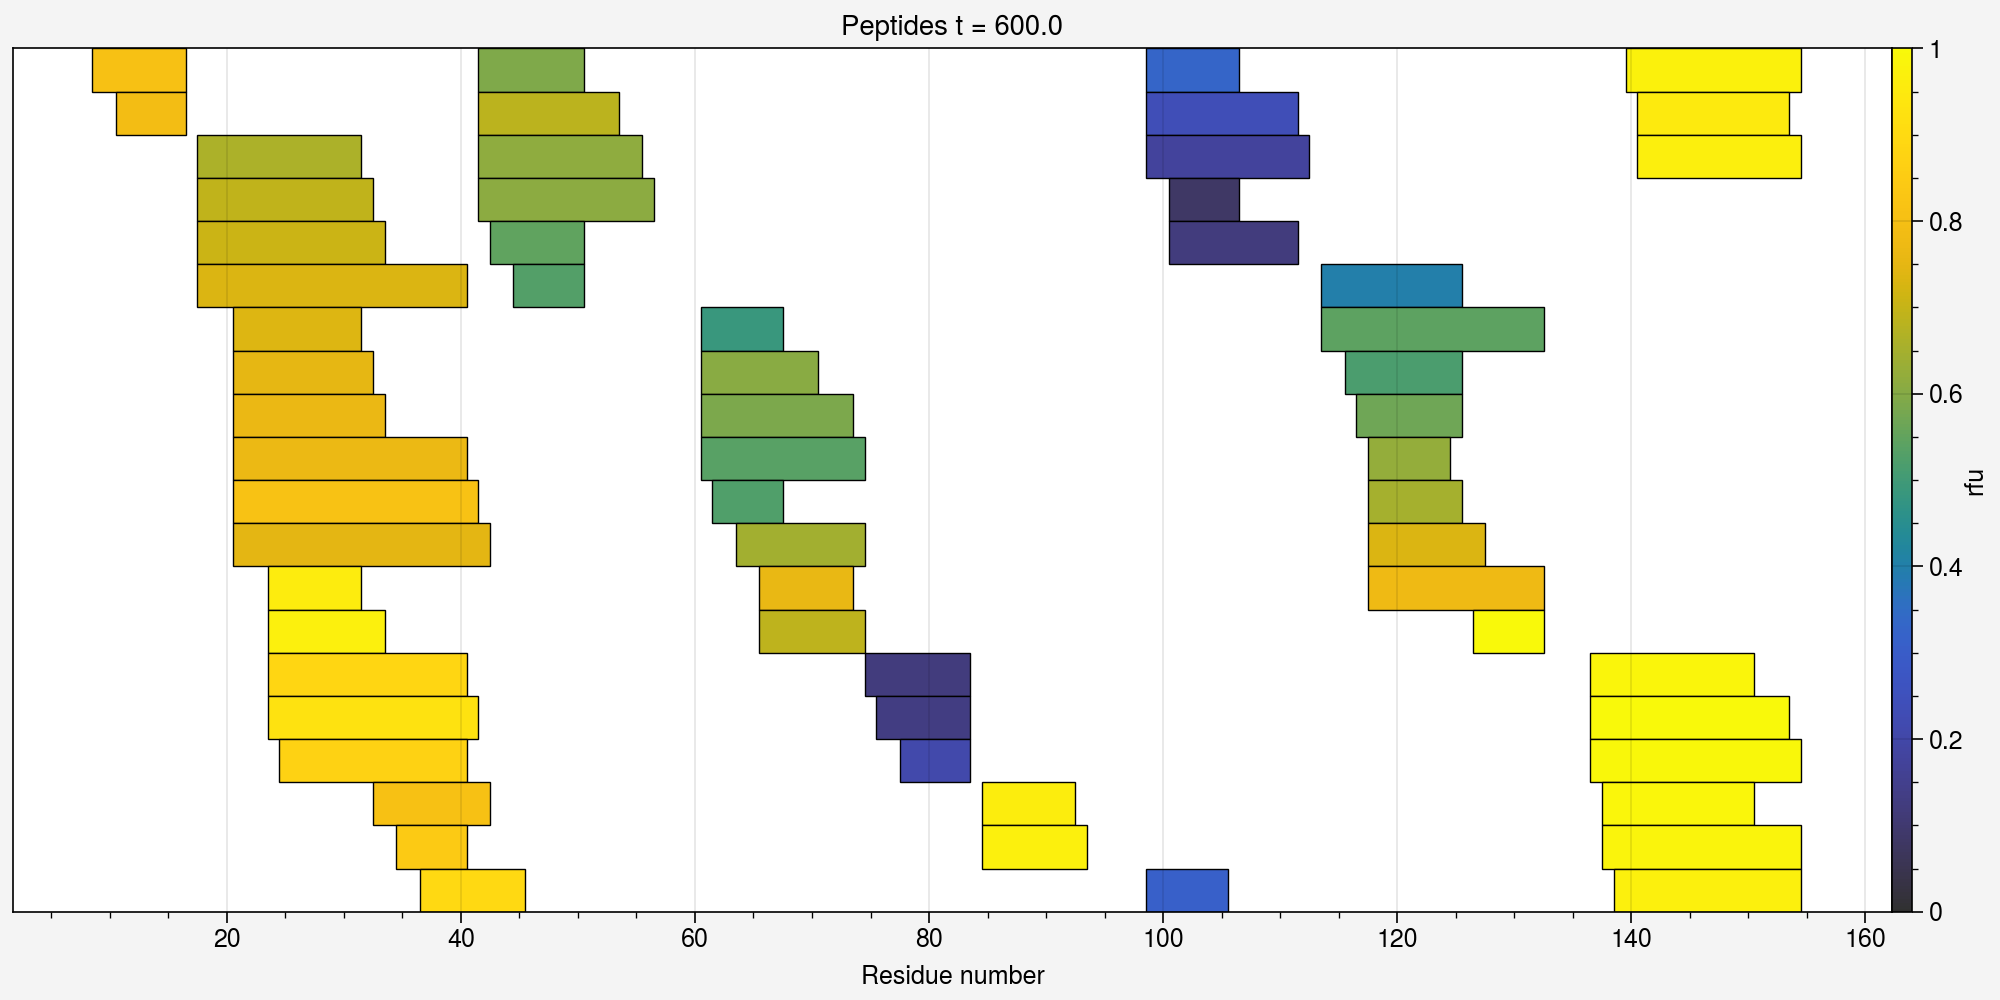

In [9]:
fig, ax = uplt.subplots(figsize=(10, 5))
i = 4
peptide_coverage(ax, hdxm[i].data, 20, cbar=True)
title = ax.set_title(f"Peptides t = {hdxm.timepoints[i]}")
label = ax.set_xlabel("Residue number")

The data in an ``HDXMeasurement`` object can be saved to and reloaded from disk (with associated metadata)
in .csv format.

In [10]:
from pyhdx.fileIO import csv_to_hdxm

hdxm.to_file("My_HDX_file.csv")
hdx_load = csv_to_hdxm("My_HDX_file.csv")
hdx_load

HDX Measurement:     My HDX measurement<br><br>Number of peptides:         63<br>Number of residues:         145 (11 - 156)<br>Number of timepoints:       6<br>Timepoints:                 10.02, 30.00, 60.00, 300.00, 600.00, 6000.00 seconds<br>Coverage Percentage:        88.39<br>Average redundancy:         5.04   <br>Average peptide length:     11.89<br>Repeatability (mean std):   0.05 Da<br>Temperature:                303.15 K<br>pH:                         8.0             <br>